In [317]:
import sys
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

sys.path.insert(1, '../')

from rule_extraction import *

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Logfiles from data-directory

In [318]:
#  YOU NEED TO CHANGE THIS PATH TO THE PATH OF THE DATA
PATH = "../data/data-cluster-examples-pause"

dataPairs = []
directories = []
for root, dirs, files in os.walk(PATH):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:
    if ("explodingLiquid" in directory):
        continue
    print(f"Processing {directory}")

    # if "fallingDrop" not in directory:
    #     print(f"Skipping {directory}")
    #     continue

    files = os.listdir(directory)

    # group files by time AutoPas_liveInfoLogger_Rank0_$2024-05-21_14-24-17$
    data_pairs = {}
    for file in files:
        if "tuningData" in file or "liveInfo" in file:
            time = file.split("_")[-1]

            if not time in data_pairs:
                data_pairs[time] = [None, None]

            if "tuningData" in file:
                data_pairs[time][1] = pd.read_csv(
                    os.path.join(directory, file))
            elif "liveInfo" in file:
                data_pairs[time][0] = pd.read_csv(
                    os.path.join(directory, file))

    # check if tuning and liveInfo files are present
    for time, pair in data_pairs.items():
        if pair[0] is None or pair[1] is None:
            print(f"Missing file for {directory} at time {time}")
            continue

    # filter rows where NaN is present

    for time, (liveInfo, tuningData) in data_pairs.items():
        tuning_iterations = tuningData["Iteration"]

        corresponding_liveInfo = liveInfo.loc[liveInfo["Iteration"].isin(
            tuning_iterations)]

        # assert len(corresponding_liveInfo) == len(
        #     tuningData), "Length of liveInfo and tuningData does not match"

        # strip columns
        corresponding_liveInfo.columns = corresponding_liveInfo.columns.str.strip()
        tuningData.columns = tuningData.columns.str.strip()

        # merge container and Data Layout
        tuningData["Container_DataLayout"] = tuningData["Container"] + \
            "_" + tuningData["Data Layout"]

        # tuningData.drop(columns=["Container", "Data Layout"], inplace=True)

        dataPairs.append((corresponding_liveInfo, tuningData))

        # describe data
        # print(f"Time: {time}")
        # print(corresponding_liveInfo["avgParticlesPerCell"].describe())
        # print("")

Processing ../data/data-cluster-examples-pause/uniformCube_b_2
Processing ../data/data-cluster-examples-pause/uniform_cube_a_2
Processing ../data/data-cluster-examples-pause/uniform_cube_a_1
Processing ../data/data-cluster-examples-pause/SpinodalDecomposition_equilibration_1
Processing ../data/data-cluster-examples-pause/SpinodalDecomposition_equilibration_2
Processing ../data/data-cluster-examples-pause/fallingDrop_2
Processing ../data/data-cluster-examples-pause/uniformCube_b_1
Processing ../data/data-cluster-examples-pause/SpinodalDecomposition_2
Processing ../data/data-cluster-examples-pause/fallingDrop_1
Processing ../data/data-cluster-examples-pause/SpinodalDecomposition_1


# Create Dataframe with all logfiles from data-directory

In [319]:
df = pd.DataFrame()

for batch, (X, y) in enumerate(dataPairs):
    merged = pd.merge(X, y, on="Iteration")
    df = pd.concat([df, merged])

df = df.drop(columns=["Iteration", "Date_x", "Date_y"])
df = df.drop(list(df.filter(regex='sample')), axis=1)
df.shape

(169634, 30)

In [320]:
df.describe()

df.head(10)

avgParticlesPerCell  cutoff  domainSizeX  domainSizeY  domainSizeZ  \
0             0.905797     3.0        93.75        78.75        68.75   
1             0.905797     3.0        93.75        78.75        68.75   
2             0.905797     3.0        93.75        78.75        68.75   
3             0.905797     3.0        93.75        78.75        68.75   
4             0.905797     3.0        93.75        78.75        68.75   
5             0.905797     3.0        93.75        78.75        68.75   
6             0.905797     3.0        93.75        78.75        68.75   
7             0.905797     3.0        93.75        78.75        68.75   
8             0.905797     3.0        93.75        78.75        68.75   
9             0.905797     3.0        93.75        78.75        68.75   

   estimatedNumNeighborInteractions  homogeneity  maxDensity  \
0                             85652     0.035863    0.107635   
1                             85652     0.035863    0.107635   
2                             85652     0.035863    0.107635   
3                             85652     0.035863    0.107635   
4                             85652     0.035863    0.107635   
5                             85652     0.035863    0.107635   
6                             85652     0.035863    0.107635   
7                             85652     0.035863    0.107635   
8                             85652     0.035863    0.107635   
9                             85652     0.035863    0.107635   

   maxParticlesPerCell  minParticlesPerCell  ...  threadCount    Container  \
0                    8                    0  ...           12  LinkedCells   
1                    8                    0  ...           12  LinkedCells   
2                    8                    0  ...           12  LinkedCells   
3                    8                    0  ...           12  LinkedCells   
4                    8                    0  ...           12  LinkedCells   
5                    8                    0  ...           12  LinkedCells   
6                    8                    0  ...           12  LinkedCells   
7                    8                    0  ...           12  LinkedCells   
8                    8                    0  ...           12  LinkedCells   
9                    8                    0  ...           12  LinkedCells   

   CellSizeFactor  Traversal  Load Estimator  Data Layout  Newton 3   Reduced  \
0             1.0     lc_c01            none          AoS  disabled  22964350   
1             1.0     lc_c01            none          SoA  disabled  21511665   
2             1.0     lc_c04            none          AoS  disabled  19633948   
3             1.0     lc_c04            none          AoS   enabled  13421045   
4             1.0     lc_c04            none          SoA  disabled  20298967   
5             1.0     lc_c04            none          SoA   enabled  14474746   
6             1.0     lc_c08            none          AoS  disabled  19792369   
7             1.0     lc_c08            none          AoS   enabled  13082756   
8             1.0     lc_c08            none          SoA  disabled  19870901   
9             1.0     lc_c08            none          SoA   enabled  13517639   

   Smoothed  Container_DataLayout  
0  22964350       LinkedCells_AoS  
1  21511665       LinkedCells_SoA  
2  19633948       LinkedCells_AoS  
3  13421045       LinkedCells_AoS  
4  20298967       LinkedCells_SoA  
5  14474746       LinkedCells_SoA  
6  19792369       LinkedCells_AoS  
7  13082756       LinkedCells_AoS  
8  19870901       LinkedCells_SoA  
9  13517639       LinkedCells_SoA  

[10 rows x 30 columns]

# Define Interesting Data to include in the Training-Data


In [321]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'Container', 'CellSizeFactor', 'Traversal', 'Load Estimator',
       'Data Layout', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

In [322]:
inputs = [
    "avgParticlesPerCell",
    "cutoff",
    "domainSizeX",
    "domainSizeY",
    "domainSizeZ",
    "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    "maxParticlesPerCell",
    "minParticlesPerCell",
    "numCells",
    "numEmptyCells",
    "numHaloParticles",
    "numParticles",
    "particleSize",
    "particleSizeNeededByFunctor",
    "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    "rebuildFrequency",
    "skin",
    "threadCount",
]

outputs = [
    "Container_DataLayout",
    "Container",
    "Data Layout",
    "CellSizeFactor",
    "Traversal",
    "Load Estimator",
    "Newton 3",
]

# Define Interesting Data to observe


In [323]:
inputs = [
    "avgParticlesPerCell",
    # "cutoff",
    # "domainSizeX",
    # "domainSizeY",
    # "domainSizeZ",
    # "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    "maxParticlesPerCell",
    # "minParticlesPerCell",
    # "numCells",
    # "numEmptyCells",
    # "numHaloParticles",
    # "numParticles",
    # "particleSize",
    # "particleSizeNeededByFunctor",
    # "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    # "rebuildFrequency",
    # "skin",
    "threadCount",
]

outputs = [
    "Container_DataLayout",
    # "Container",
    # "Data Layout",
    # "CellSizeFactor",
    "Traversal",
    # "Load Estimator",
    "Newton 3",
]

# Only keep data, known to perform well (SPEEDUP_CUT)

In [324]:
SPEEDUP_CUT = 0.7

group_by = [
    "avgParticlesPerCell",
    "cutoff",
    "domainSizeX",
    "domainSizeY",
    "domainSizeZ",
    "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    "maxParticlesPerCell",
    "minParticlesPerCell",
    "numCells",
    "numEmptyCells",
    "numHaloParticles",
    "numParticles",
    "particleSize",
    "particleSizeNeededByFunctor",
    "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    "rebuildFrequency",
    "skin",
    "threadCount",
]


# only keep rows where performance percentage is above x
print("Orignal length", len(df))

# group data on input columns
grouped = df.groupby(group_by)


def add_Speedup_column(group):
    min_smoothed = group['Smoothed'].min()
    result = group.copy()
    result['speedup'] = min_smoothed / result['Smoothed']
    return result


grouped_speedup = grouped.apply(
    add_Speedup_column).reset_index(drop=True)

grouped_speedup.drop(columns=["Smoothed", "Reduced"], inplace=True)


def filter_groups(group):
    return group[group['speedup'] > SPEEDUP_CUT]

 # only keep rows where best_smoothed/current_smoothed is above 0.7
filtered_groups = grouped_speedup.groupby(
    group_by).apply(filter_groups).reset_index(drop=True)


print("Filtered length", len(filtered_groups))


def unique_string_elems(row):
    return ", ".join(sorted(map(str, list(np.unique(row)))))


# Combine all string columns into unique values
combined = filtered_groups.groupby(inputs).agg(
    unique_string_elems).reset_index()

print("Combined length", len(combined))

Orignal length 169634


/tmp/ipykernel_89417/2307988425.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speedup = grouped.apply(
/tmp/ipykernel_89417/2307988425.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_by).apply(filter_groups).reset_index(drop=True)


Filtered length 23757
Combined length 3121


# Filter Data / Outliers


In [325]:
Z_THRESHHOLD = 1000
for column in inputs:
    z = np.abs(stats.zscore(combined[column]))
    combined = combined[z < Z_THRESHHOLD]

print("Outliers removed length", len(combined))


# filter values occuring less than pct
SPARSE_CUTOFF = 0.01
for column in outputs:
    counts = combined[column].value_counts()

    sparse_values = combined[column].isin(
        counts[counts > len(combined) * SPARSE_CUTOFF].index)

    combined = combined[sparse_values]


print("Sparse values removed length", len(combined))

X, y = combined[inputs], combined[outputs]
print(X.shape, y.shape)

Outliers removed length 3121
Sparse values removed length 2716
(2716, 6) (2716, 3)


# Create Train and Test Data


In [326]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# save to csv
pd.concat([X_train, y_train], axis=1).to_pickle("train.pkl")
pd.concat([X_test, y_test], axis=1).to_pickle("test.pkl")

# Final Data


In [327]:
pd.concat([X_train, y_train], axis=1).head()

avgParticlesPerCell  homogeneity  maxDensity  maxParticlesPerCell  \
1973             0.905797     0.055112    0.297891                   15   
2823             0.944637     0.084061    0.673320                   25   
2703             0.944637     0.083134    0.479880                   22   
1395             0.905797     0.041394    0.336900                   20   
1463             0.905797     0.042934    0.195048                   13   

      particlesPerCellStdDev  threadCount  \
1973                0.015171            4   
2823                0.039916           24   
2703                0.040607           12   
1395                0.013546           24   
1463                0.012013           28   

                                   Container_DataLayout  \
1973  LinkedCells_SoA, VerletClusterLists_SoA, Verle...   
2823  LinkedCells_SoA, VerletClusterLists_SoA, Verle...   
2703  LinkedCells_SoA, VerletClusterLists_SoA, Verle...   
1395       VerletClusterLists_SoA, VerletListsCells_AoS   
1463       VerletClusterLists_SoA, VerletListsCells_AoS   

                                              Traversal           Newton 3  
1973  lc_sliced, lc_sliced_balanced, lc_sliced_c02, ...            enabled  
2823  lc_c04, lc_c08, lc_sliced, lc_sliced_balanced,...  disabled, enabled  
2703  lc_c04, lc_c08, lc_sliced, lc_sliced_balanced,...            enabled  
1395          vcl_c06, vlc_c01, vlc_c18, vlc_sliced_c02  disabled, enabled  
1463          vcl_c06, vlc_c01, vlc_c18, vlc_sliced_c02  disabled, enabled

# Train Decision Tree and Extract Rules


In [328]:
# number of input parameters that can be used simultaneously
POSSIBLE_NUMBER_OF_COMBINATIONS = [2, 3, 4, 5]

CCP_ALPHA = {
    "Container_DataLayout": 0.1,
    "Traversal": 0.08,
    "Newton 3": 0.02,
}

# maximum depth of the decision tree
MAX_DEPTH = 10

# how many models should be created for each label
TOP_K_MODELS_PER_LABEL = 2


Training on 2172 samples
Number of rules 50:
	Container_DataLayout (14 rules)
	Traversal (22 rules)
	Newton 3 (14 rules)


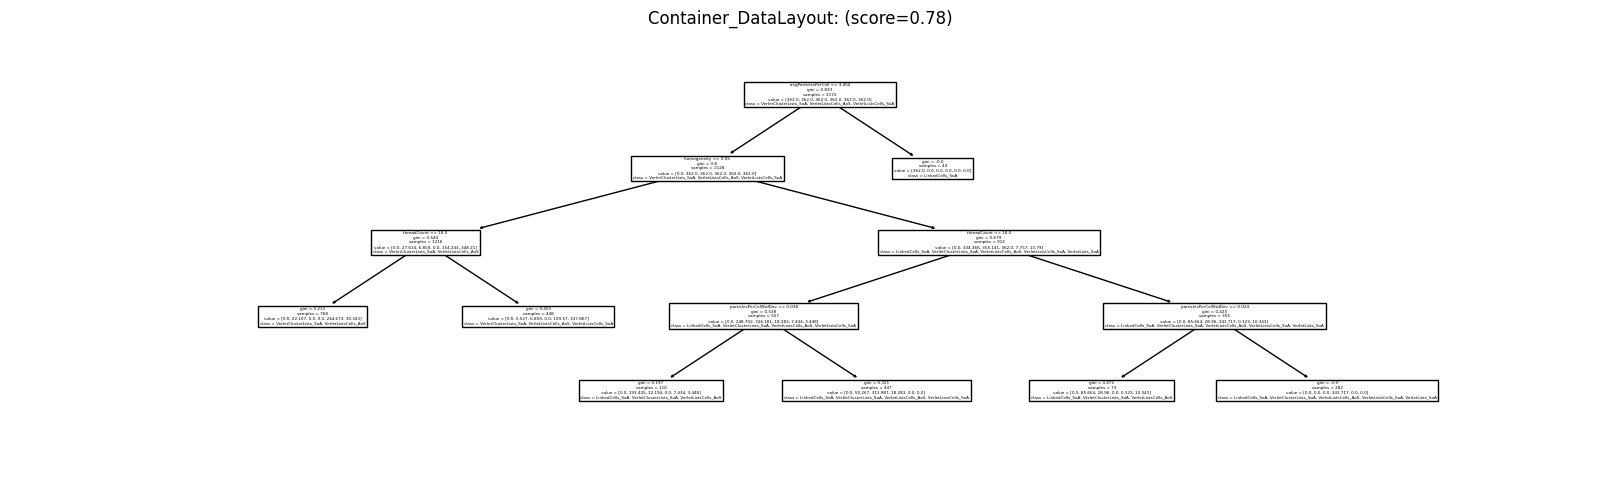

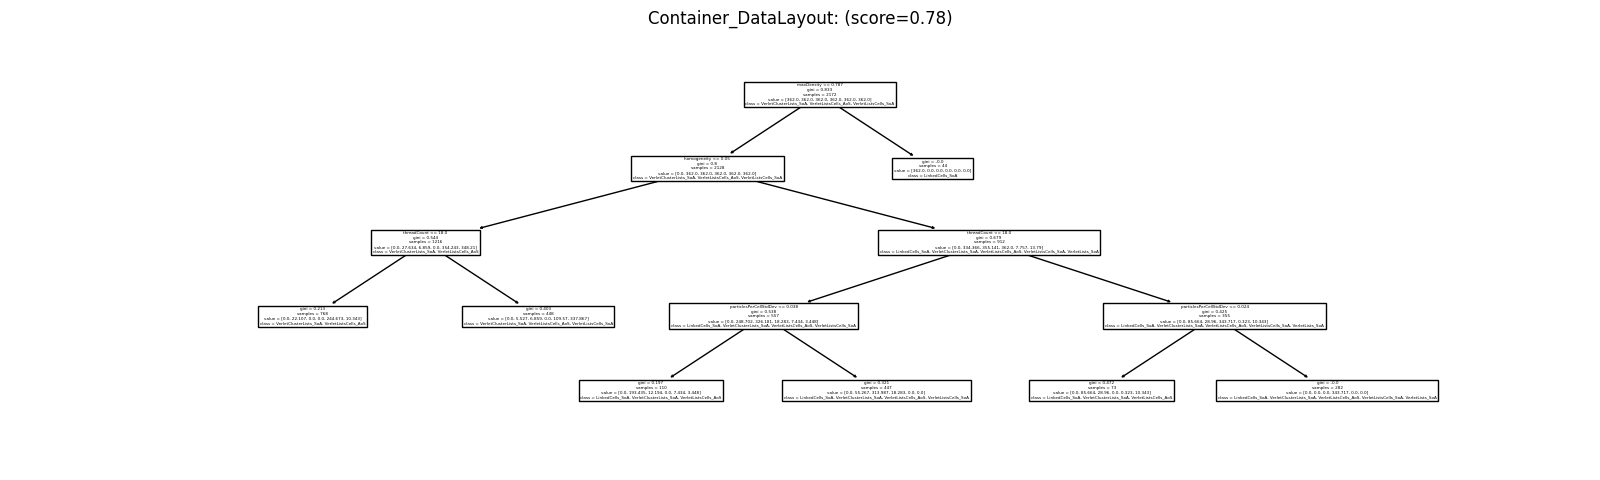

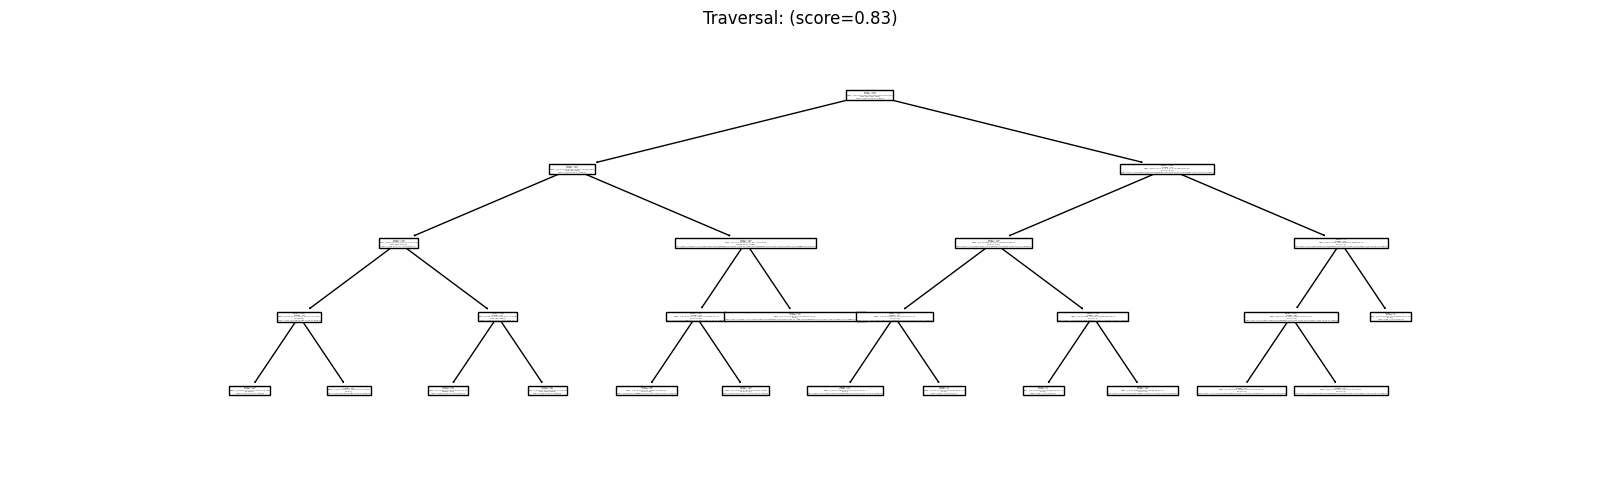

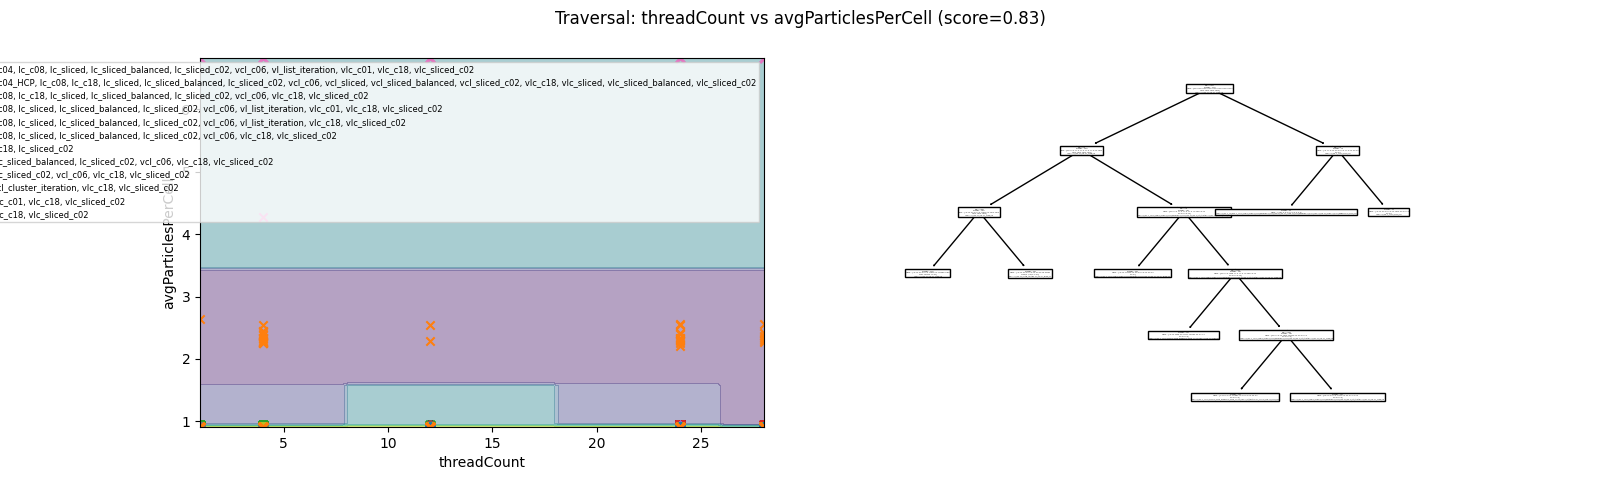

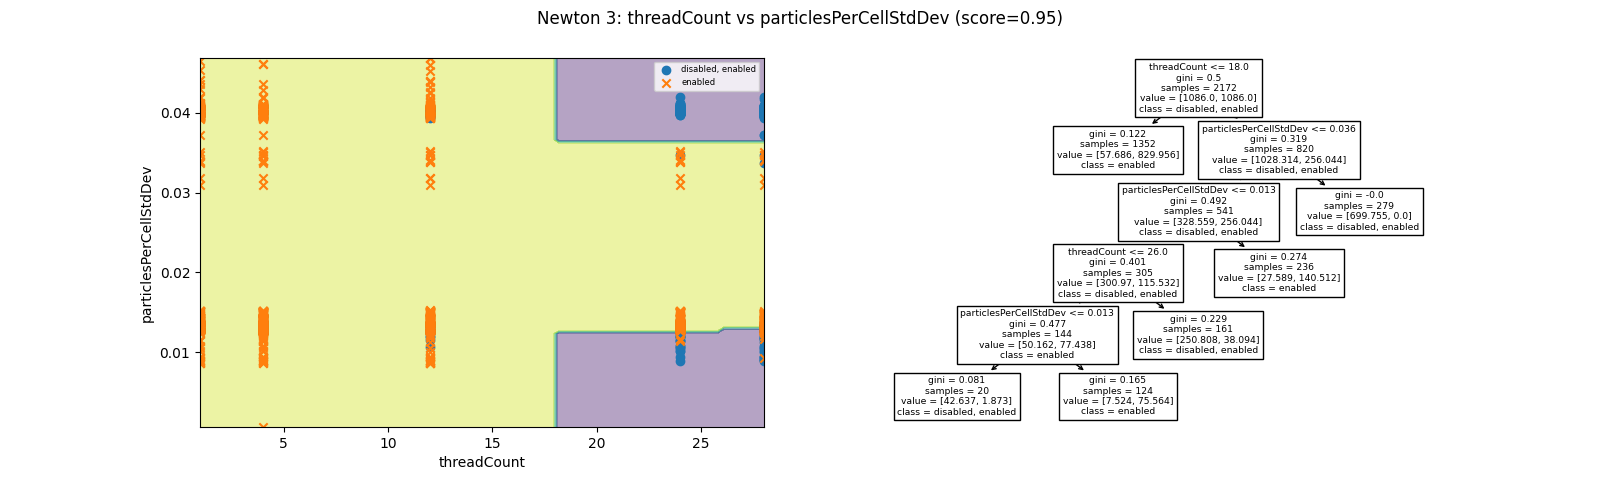

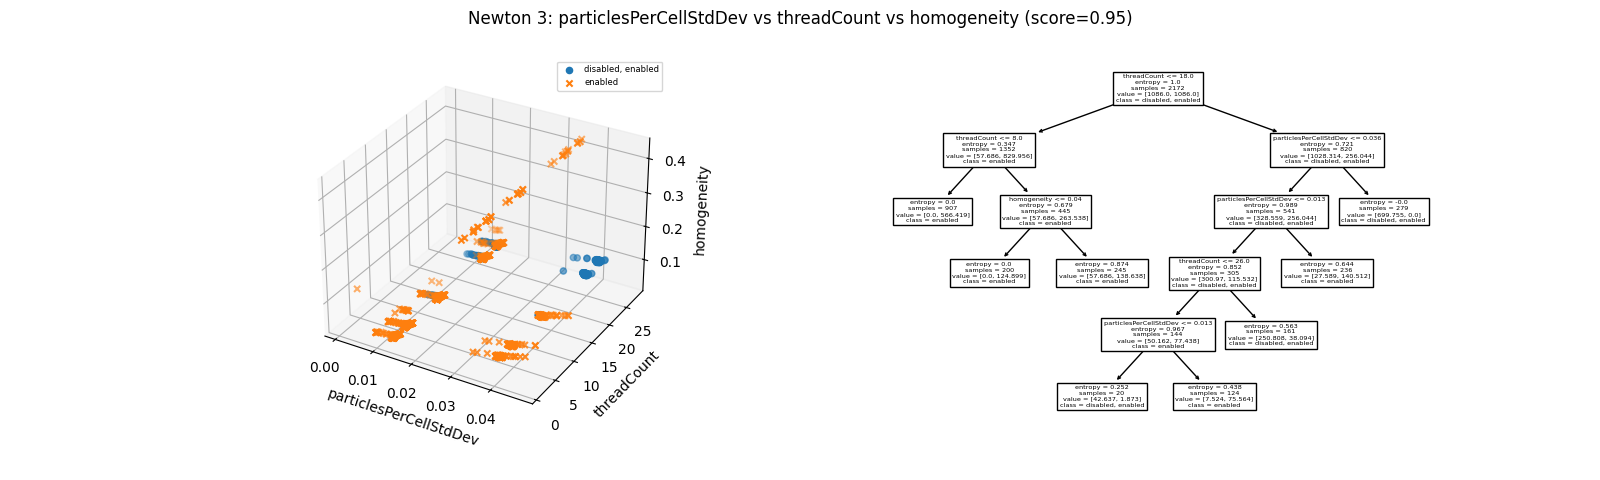

In [329]:
auto_rules = create_auto_rules(X_train, y_train,  None,
                               POSSIBLE_NUMBER_OF_COMBINATIONS, CCP_ALPHA, MAX_DEPTH, TOP_K_MODELS_PER_LABEL)

# Aproach 2

Follows https://www.sciencedirect.com/science/article/pii/S0165011406002533


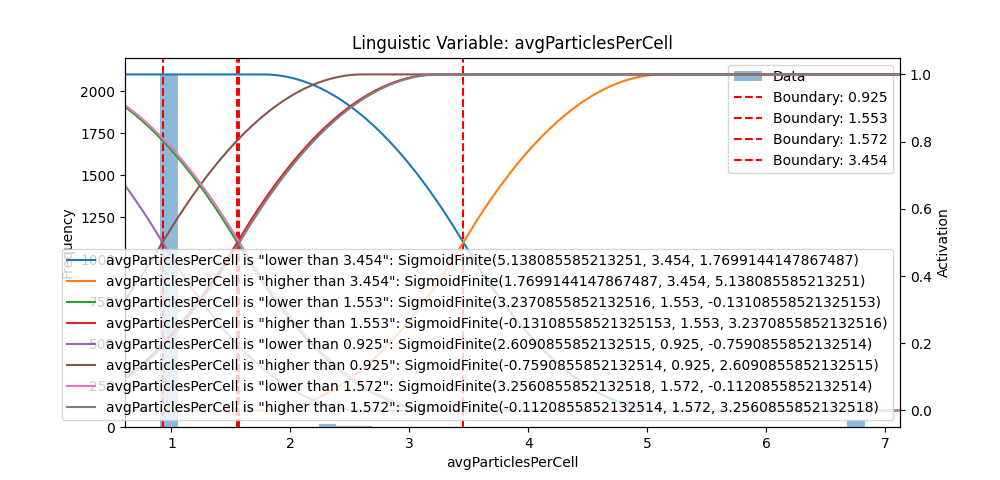

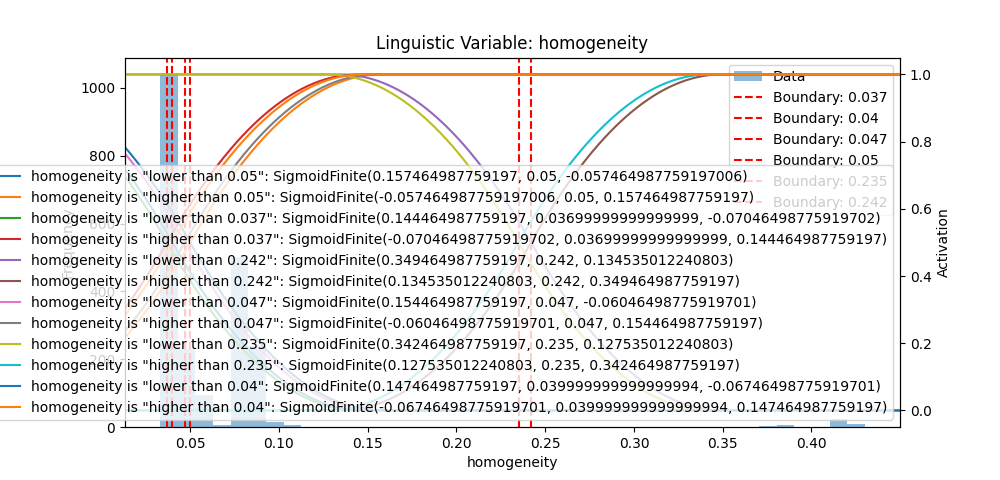

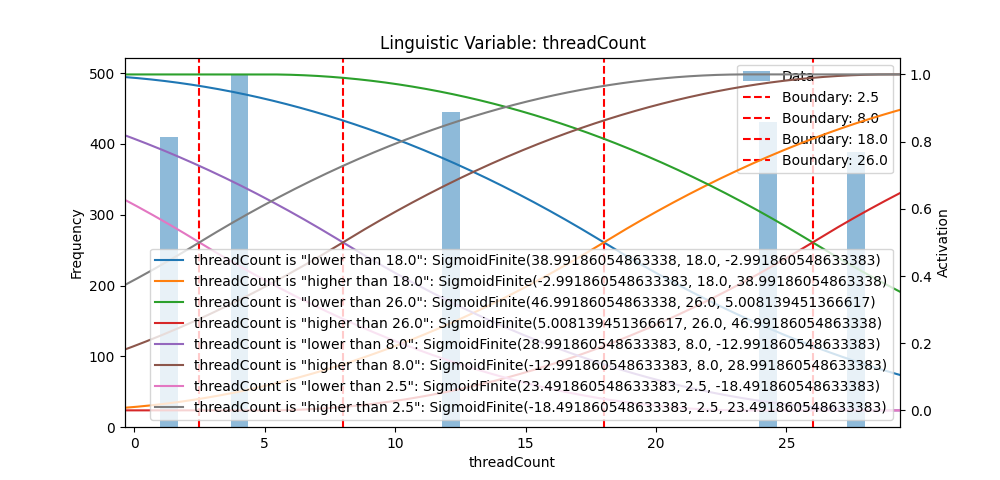

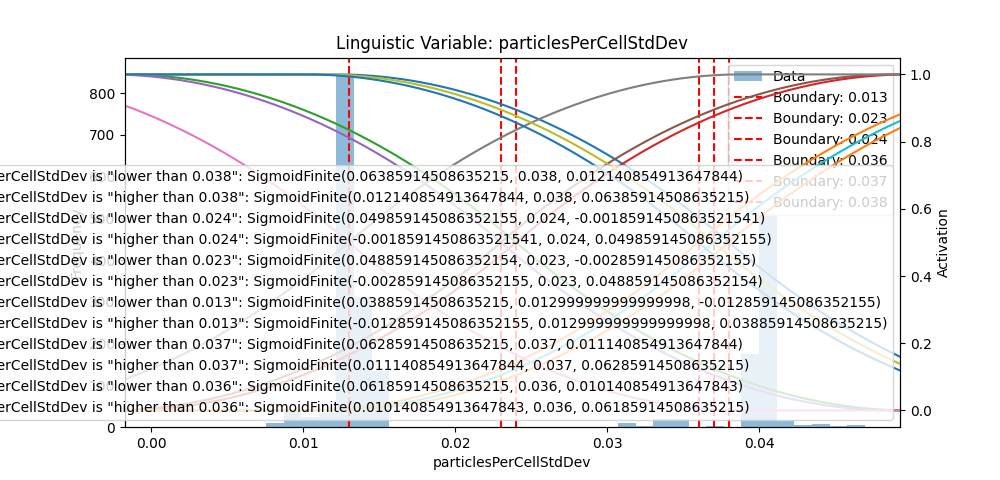

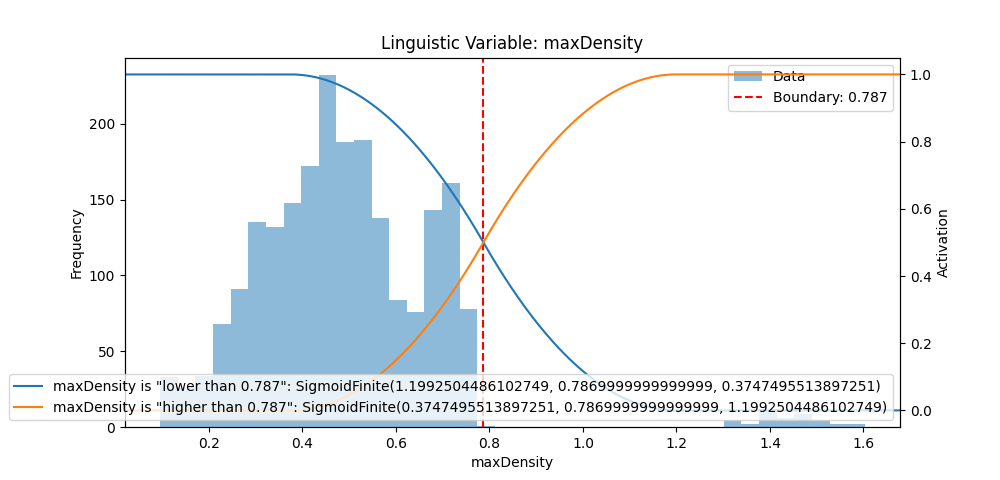

In [330]:
inputVariables, rules = create_rules_approach2(
    X_train, auto_rules)

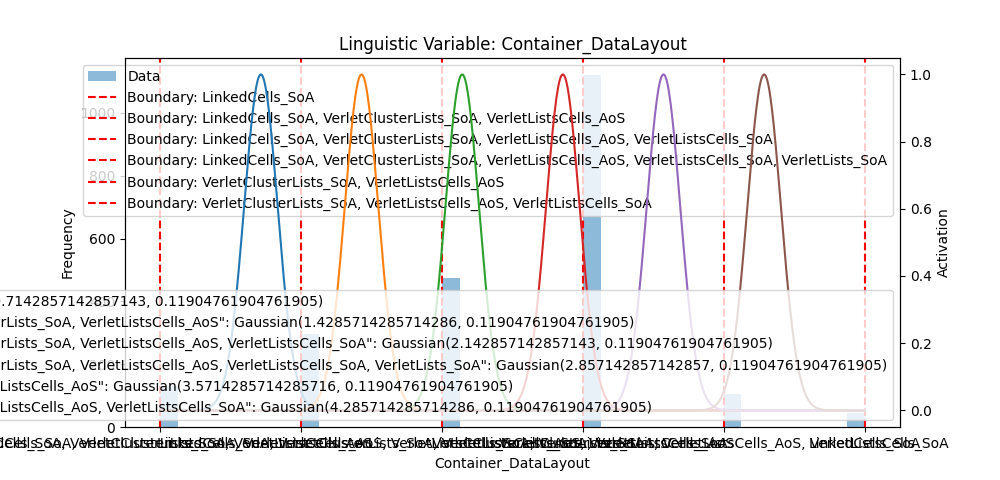

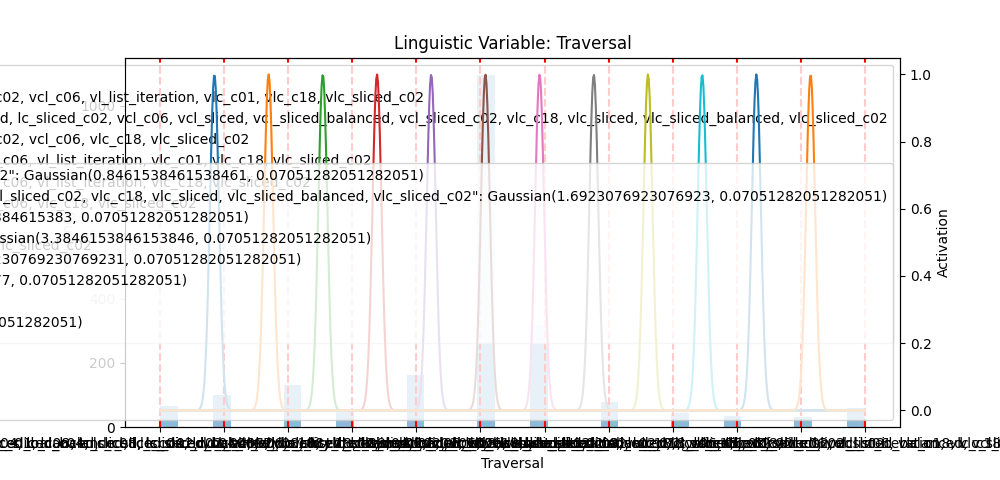

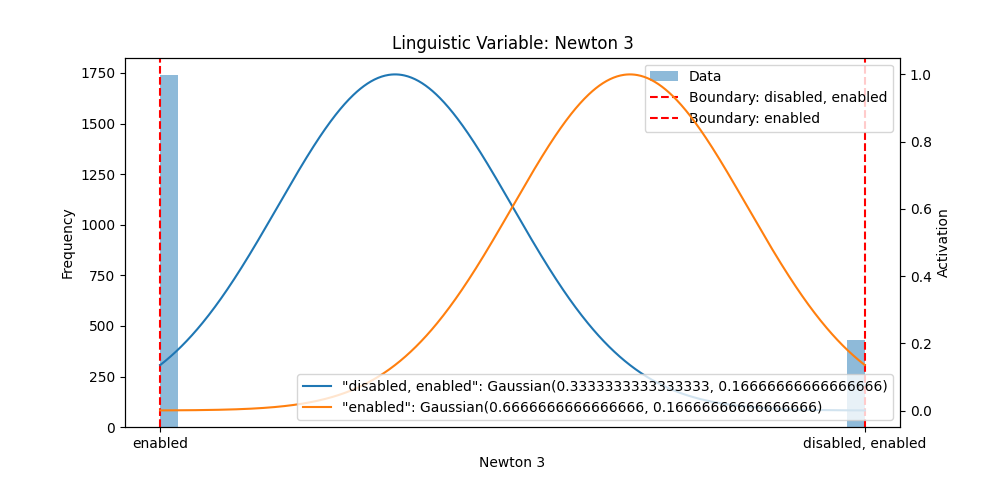

In [331]:
outputVariables = create_output_membership_functions(y_train)

In [332]:
print(outputVariables)

{'Container_DataLayout': FuzzyVariable({('Container_DataLayout', Set(SetType.CONTINUOUS, (0, 5)))}) with sets: [LinkedCells_SoA, LinkedCells_SoA, VerletClusterLists_SoA, VerletListsCells_AoS, LinkedCells_SoA, VerletClusterLists_SoA, VerletListsCells_AoS, VerletListsCells_SoA, LinkedCells_SoA, VerletClusterLists_SoA, VerletListsCells_AoS, VerletListsCells_SoA, VerletLists_SoA, VerletClusterLists_SoA, VerletListsCells_AoS, VerletClusterLists_SoA, VerletListsCells_AoS, VerletListsCells_SoA], 'Traversal': FuzzyVariable({('Traversal', Set(SetType.CONTINUOUS, (0, 11)))}) with sets: [lc_c01, lc_c04, lc_c08, lc_sliced, lc_sliced_balanced, lc_sliced_c02, vcl_c06, vl_list_iteration, vlc_c01, vlc_c18, vlc_sliced_c02, lc_c04, lc_c04_HCP, lc_c08, lc_c18, lc_sliced, lc_sliced_balanced, lc_sliced_c02, vcl_c06, vcl_sliced, vcl_sliced_balanced, vcl_sliced_c02, vlc_c18, vlc_sliced, vlc_sliced_balanced, vlc_sliced_c02, lc_c04, lc_c08, lc_c18, lc_sliced, lc_sliced_balanced, lc_sliced_c02, vcl_c06, vlc_c18

In [333]:
def createOutputMapping(output_variables):
    outputMapping = {}

    for output_variable, membership_functions in output_variables.items():
        outputMapping[output_variable] = f"  \"{output_variable}\":\n"

        for term, membership_function in membership_functions.linguistic_terms.items():
            mean = membership_function.peak()

            template = "[? = \"?\"] "
            num_terms = len(term.split(", "))

            outputMapping[output_variable] += f"{" "*25+"#"+term}\n  {
                mean} =>  {", ".join([template for _ in range(num_terms)])}\n"

    return outputMapping


output_mapping = createOutputMapping(outputVariables)

In [334]:
display(rules_to_table(rules, "Approach 2"))

/home/manuel/AutoPas-FuzzyTuning-Bachelor-Thesis/data-analysis/rule_extraction.py:939: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  table = table.applymap(
/home/manuel/AutoPas-FuzzyTuning-Bachelor-Thesis/data-analysis/rule_extraction.py:942: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  table = table.applymap(


# Save all the data


In [335]:
save_linguistic_variables(
    inputVariables, "component-rules/fuzzy-inputs.txt")
save_linguistic_variables(outputVariables,
                          "component-rules/fuzzy-outputs.txt")

save_fuzzy_rules(rules, "component-rules/fuzzy-rules.txt")

In [336]:
FRULE_TEMPLATE = """# Setup

# Here global settings for all fuzzy systems can be defined.
# Currently it is not possible to define different settings for different fuzzy systems.
FuzzySystemSettings:
    defuzzificationMethod: "meanOfMaximum"
    interpretOutputAs: "IndividualSystems"


# Fuzzy Variables

# Next all of the fuzzy variables are defined. Each fuzzy variable has a domain and a range.
# The domain specifies the input for the fuzzy variable. At the moment it is only possible to use
# values of the LiveInfoStruct as domain. The range of this variable also needs to be passed as it
# is important for the defuzzification process.
# Each fuzzy variable can have multiple fuzzy sets. Each fuzzy set is defined by a name and a membership function.

{{INPUT_VARIABLES}}

{{OUTPUT_VARIABLES}}    


# Output Mapping

# The OutputMapping specify how the results of the fuzzy system should be mapped to the actual configurations which should be tested.
# In this case each fuzzy variable only has a single configuration, namely itself. You need to fill this in manually. Sorry :( (Each lingustic term should be mapped to a configuration e.g: "LinkedCells_SoA, VerletClusterLists_SoA, VerletListsCells_AoS" should receive three configurations [container="LinkedCells", dataLayout="SoA"], [container="VerletClusterLists", dataLayout="SoA"], [container="VerletListsCells", dataLayout="AoS"] at the corresponding value)

{{OUTPUT_MAPPING}}

# Rules

# The rules define how the input variables are combined to output variables and should encode the expert knowledge.
# The rules are defined in a simple if-then format.

{{RULES}}
"""


def create_frule_file(inputs, outputs, rules, output_mapping):
    input_variables = format_linguistic_variables(inputs)
    output_variables = format_linguistic_variables(outputs)
    rules = format_rules(rules)

    output_mapping = "OutputMapping:\n" + \
        "\n".join([output_mapping[key] for key in output_mapping])

    fruleFile = FRULE_TEMPLATE.replace(
        "{{INPUT_VARIABLES}}", input_variables).replace("{{OUTPUT_VARIABLES}}", output_variables).replace("{{OUTPUT_MAPPING}}", output_mapping).replace("{{RULES}}", rules)

    with open("component-rules/fuzzyrules-components.frule", "w") as file:
        file.write(fruleFile)

In [337]:
create_frule_file(inputVariables, outputVariables, rules, output_mapping)